<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dataretrieval
!pip install pygris
import pygris
import glob
import os
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from shapely import Point
from scipy.stats import linregress

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.8 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Load gages for 34 gage validation

In [88]:
# gage_pts_1 = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.shp')[['iindex', 'site_no']]
gage_pts = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_3.shp')[['site_no', 'iindex', 'geometry']]
gage_pts = gage_pts.loc[gage_pts.site_no != '06794500'] # all P quality code
gage_pts = gage_pts.merge(gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250927.shp')[['iindex', 'riv_length']], on='iindex')
gage_list = gage_pts.site_no.tolist()
gage_pts

,site_no,iindex,geometry,riv_length
0,06764880,225467,POINT (-101.57667 41.12611),172.516752
1,06775900,75941,POINT (-100.52528 41.77861),92.934030
2,06775500,77597,POINT (-100.09953 41.83092),74.194767
3,06770200,217337,POINT (-99.08611 40.65806),1399.403363
4,06767970,245153,POINT (-99.56796 40.67684),923.997749
5,06768000,244511,POINT (-99.54056 40.6825),907.346015
6,06784000,259030,POINT (-98.74056 41.0325),216.935252
7,06781900,210361,POINT (-99.70861 41.19278),106.830719
8,06785000,157059,POINT (-98.44611 41.2035),574.579112
9,06790500,168277,POINT (-98.44924 41.26335),483.536907


Discharge

In [89]:
# sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']
sites = gage_list

# first and last dates same as for in situ widths
# start = str(isw.index.sortlevel(1)[0][0][1])
# end = str(isw.index.sortlevel(1)[0][-1][1])
start = '2000-01-01'
end = None

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean', '00060_Mean_cd']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
# Q['00065_Mean'] = Q['00065_Mean'] * (3.28 ** -1)
Q = Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd'})
# Q = Q.loc[Q.Q_cd == 'A']
# Q['Q_percentile'] = Q.groupby('site_no')['Q_cms'].rank(pct=True)
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms  Q_cd
site_no  date                        
06620000 2000-01-01    3.684019  A, e
         2000-01-02    3.400633  A, e
         2000-01-03    3.117247  A, e
         2000-01-04    2.833861  A, e
         2000-01-05    2.720506  A, e
...                         ...   ...
06800500 2025-09-24  106.269769     P
         2025-09-25   75.380689     P
         2025-09-26   58.094140     P
         2025-09-27   59.794457     P
         2025-09-28   60.077843     P

[275458 rows x 2 columns]

Load in effective width\
See stac_processing_download.ipynb

In [6]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    # width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_g2_20250921.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_gx_20250927.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[(allwidths.n_valid == allwidths.n_pixels) & (allwidths.n_valid > -999)]


allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,2024-03-10,0
445,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,2024-03-10,0
447,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,2024-12-19,0
448,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,14TQL,2024-10-20,0


Join widths and gage ids

In [7]:
allwidths = pd.merge(allwidths, gage_pts, how='left', on='iindex')
allwidths = allwidths.rename(columns={'gage_id': 'site_no'})
allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version,site_no,riv_length
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1,06764880,172.516752
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0,06800000,148.276448
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1,06635000,93.794831
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1,06630000,480.468419
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1,06797500,286.834439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14825,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,2024-03-10,0,06768000,907.346015
14826,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,2024-03-10,0,06767970,923.997749
14827,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,2024-12-19,0,06799350,472.125623
14828,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,14TQL,2024-10-20,0,06800500,372.624481


Calculate effective width and fractions of cloud and snow

In [8]:
allwidths['sat_width_m'] = allwidths.n_river * 100 / allwidths.riv_length
allwidths['fraction_cloud'] = allwidths.n_cloud / allwidths.n_pixels
allwidths['fraction_snow'] = allwidths.n_snow / allwidths.n_pixels
allwidths['fraction_edgeriver'] = allwidths.n_edgeriver / allwidths.n_edge
allwidths = allwidths.set_index(['site_no', 'date'])
allwidths

,,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,version,riv_length,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver
site_no,date,,,,,,,,,,,,,,,,,,
06764880,2018-06-23,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,1,172.516752,39.996116,0.000000,0.000000,0.209302
06800000,2018-10-15,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,0,148.276448,18.209230,0.024390,0.000000,0.093023
06635000,2018-06-11,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,1,93.794831,13.860039,0.000000,0.000000,0.133333
06630000,2018-06-11,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,1,480.468419,31.635794,0.069388,0.000000,0.060870
06797500,2018-06-22,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,1,286.834439,25.101588,0.443548,0.000000,0.040541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06768000,2024-03-10,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,0,907.346015,146.140500,0.000000,0.000000,0.115226
06767970,2024-03-10,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,0,923.997749,83.008860,0.000000,0.000000,0.083333
06799350,2024-12-19,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,0,472.125623,69.049419,0.000000,0.019257,0.153226


In [9]:
widths_filtered = allwidths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
print(len(widths_filtered))
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
print(len(widths_filtered))
# widths_filtered = widths_filtered.loc[(widths_filtered.n_cloud - widths_filtered.n_cloudriver / widths_filtered.n_valid) < 0.4]
print(len(widths_filtered))
# widths_filtered = widths_filtered.loc[widths_filtered.fraction_edgeriver < 0.3]
print(len(widths_filtered))
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]
print(len(widths_filtered))


widths_filtered['width_percentile'] = widths_filtered.groupby('site_no')['sat_width_m'].rank(pct=True)
# widths_filtered

13364
11730
11730
11730
6653


Filter Q for quality, calculate percentiles

In [91]:
Q_filtered = Q.copy()
Q_filtered = Q_filtered.loc[Q_filtered.Q_cd == 'A']
Q_filtered = Q_filtered.loc[Q_filtered.Q_cms > 0]

Q_filtered['Q_percentile'] = Q_filtered.groupby('site_no')['Q_cms'].rank(pct=True)

Q_filtered
# print(len(Q_filtered))

Q_cms Q_cd  Q_percentile
site_no  date                                    
06620000 2000-04-05  10.882024    A      0.611830
         2000-04-06  16.379714    A      0.703352
         2000-04-07  19.695331    A      0.750621
         2000-04-08  17.314888    A      0.718340
         2000-04-09  19.922039    A      0.753725
...                        ...  ...           ...
06800500 2025-05-16  20.828875    A      0.170988
         2025-05-17  20.177087    A      0.164198
         2025-05-18  19.695331    A      0.158573
         2025-05-19  22.557530    A      0.188820
         2025-05-20  79.064708    A      0.772222

[226883 rows x 3 columns]

Join gage discharge and sat width on date

In [11]:
wQ = Q_filtered.join(widths_filtered, how='outer').reset_index()
wQ = wQ.set_index(['site_no', 'date'])
wQ

Q_cms Q_cd  Q_percentile  Unnamed: 0 img_id  iindex  \
site_no  date                                                                  
06620000 2000-04-05  10.882024    A      0.611830         NaN    NaN     NaN   
         2000-04-06  16.379714    A      0.703352         NaN    NaN     NaN   
         2000-04-07  19.695331    A      0.750621         NaN    NaN     NaN   
         2000-04-08  17.314888    A      0.718340         NaN    NaN     NaN   
         2000-04-09  19.922039    A      0.753725         NaN    NaN     NaN   
...                        ...  ...           ...         ...    ...     ...   
06800500 2025-05-16  20.828875    A      0.170988         NaN    NaN     NaN   
         2025-05-17  20.177087    A      0.164198         NaN    NaN     NaN   
         2025-05-18  19.695331    A      0.158573         NaN    NaN     NaN   
         2025-05-19  22.557530    A      0.188820         NaN    NaN     NaN   
         2025-05-20  79.064708    A      0.772222         NaN    NaN     NaN   

                     n_pixels  n_valid  n_river  n_cloud  ...  n_edge  \
site_no  date                                             ...           
06620000 2000-04-05       NaN      NaN      NaN      NaN  ...     NaN   
         2000-04-06       NaN      NaN      NaN      NaN  ...     NaN   
         2000-04-07       NaN      NaN      NaN      NaN  ...     NaN   
         2000-04-08       NaN      NaN      NaN      NaN  ...     NaN   
         2000-04-09       NaN      NaN      NaN      NaN  ...     NaN   
...                       ...      ...      ...      ...  ...     ...   
06800500 2025-05-16       NaN      NaN      NaN      NaN  ...     NaN   
         2025-05-17       NaN      NaN      NaN      NaN  ...     NaN   
         2025-05-18       NaN      NaN      NaN      NaN  ...     NaN   
         2025-05-19       NaN      NaN      NaN      NaN  ...     NaN   
         2025-05-20       NaN      NaN      NaN      NaN  ...     NaN   

                     n_edgeriver  mgrs  version riv_length sat_width_m  \
site_no  date                                                            
06620000 2000-04-05          NaN   NaN      NaN        NaN         NaN   
         2000-04-06          NaN   NaN      NaN        NaN         NaN   
         2000-04-07          NaN   NaN      NaN        NaN         NaN   
         2000-04-08          NaN   NaN      NaN        NaN         NaN   
         2000-04-09          NaN   NaN      NaN        NaN         NaN   
...                          ...   ...      ...        ...         ...   
06800500 2025-05-16          NaN   NaN      NaN        NaN         NaN   
         2025-05-17          NaN   NaN      NaN        NaN         NaN   
         2025-05-18          NaN   NaN      NaN        NaN         NaN   
         2025-05-19          NaN   NaN      NaN        NaN         NaN   
         2025-05-20          NaN   NaN      NaN        NaN         NaN   

                     fraction_cloud  fraction_snow  fraction_edgeriver  \
site_no  date                                                            
06620000 2000-04-05             NaN            NaN                 NaN   
         2000-04-06             NaN            NaN                 NaN   
         2000-04-07             NaN            NaN                 NaN   
         2000-04-08             NaN            NaN                 NaN   
         2000-04-09             NaN            NaN                 NaN   
...                             ...            ...                 ...   
06800500 2025-05-16             NaN            NaN                 NaN   
         2025-05-17             NaN            NaN                 NaN   
         2025-05-18             NaN            NaN                 NaN   
         2025-05-19             NaN            NaN                 NaN   
         2025-05-20             NaN            NaN                 NaN   

                     width_percentile  
site_no  date                          
06620000 2000-04-05         

In [12]:

bins10 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bins5 = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bins20 = np.arange(0, 1.05, 0.05).tolist()
bins100 = np.arange(0, 1.01, 0.01)
bins4 = np.arange(0, 1.25, 0.25).tolist()
bins = bins4
bins50 = np.arange(0, (1 + (1 / 50)), (1 / 50))
bins25 = np.arange(0, (1 + (1 / 25)), (1 / 25))

all_allbins = []

for bins in [bins5, bins10, bins20, bins25, bins50, bins100]:
    wQ['width_percentile_bin'] = wQ.groupby('site_no')['width_percentile'].transform(
        lambda x: pd.cut(x, bins=bins, labels=False)
    )
    wQ['Q_percentile_bin'] = wQ.groupby('site_no')['Q_percentile'].transform(
        lambda x: pd.cut(x, bins=bins, labels=False)
    )

    Qbins = wQ.groupby(['Q_percentile_bin']).agg(
        mean_bin_Q = ('Q_cms', 'mean'),
        median_bin_Q = ('Q_cms', 'median')
    ).rename_axis(index={'Q_percentile_bin': 'percentile_bin'})

    wbins = wQ.groupby(['width_percentile_bin']).agg(
        mean_bin_w = ('sat_width_m', 'mean'),
        median_bin_w = ('sat_width_m', 'median')
    ).rename_axis(index={'width_percentile_bin': 'percentile_bin'})

    allbins = Qbins.join(wbins)

    all_allbins.append(allbins)

binnos = [5, 10, 20, 25, 50, 100]


0
1
2
3
4
5


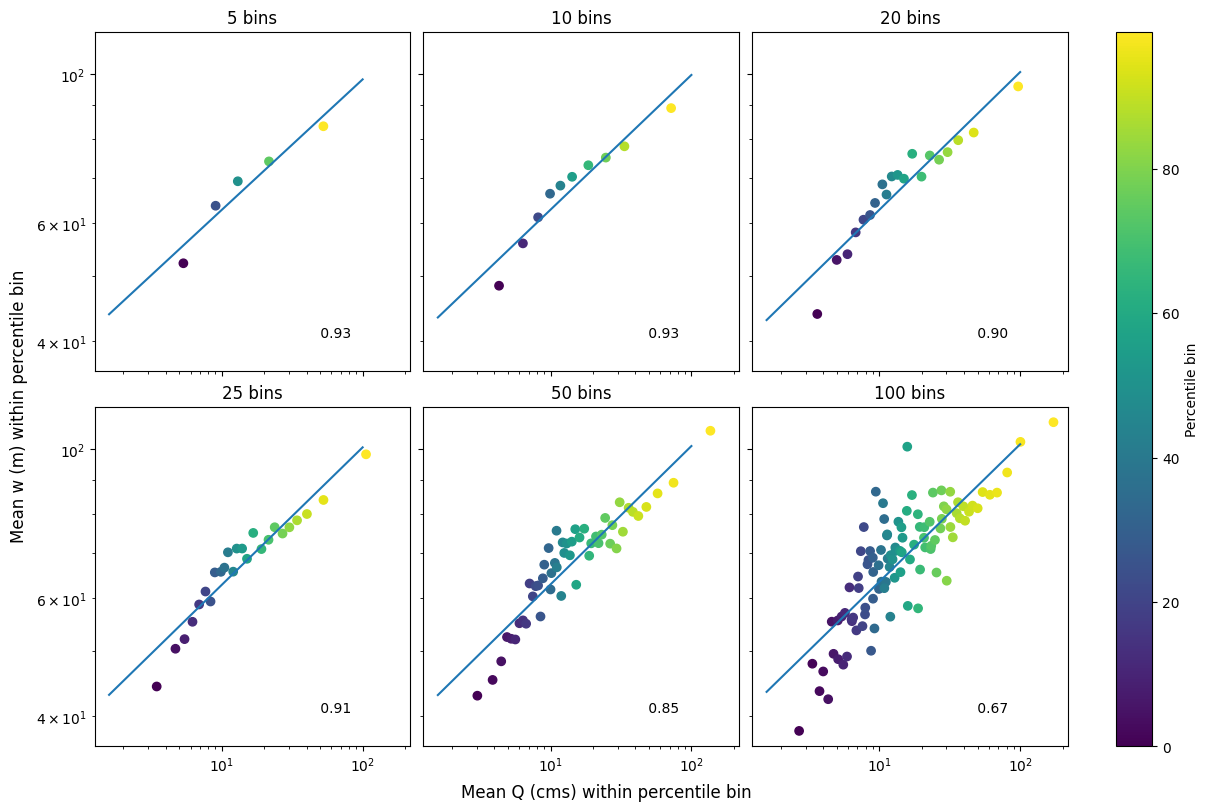

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, sharex=True, sharey=True, figsize=(12, 8))
fig.supxlabel('Mean Q (cms) within percentile bin')
fig.supylabel('Mean w (m) within percentile bin')
lrstats = []

for i in range(len(all_allbins)):
    print(i)
    allbins = all_allbins[i]
    color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown']
    ax = axs.flatten()[i]
    dat = ax.scatter(allbins.mean_bin_Q, allbins.mean_bin_w, c=allbins.index)
    # ax.scatter(allbins.median_bin_Q, allbins.median_bin_w, c=color[i], marker='^', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{binnos[i]} bins')


    lrs = linregress(np.log10(allbins.mean_bin_Q), np.log10(allbins.mean_bin_w))

    lrstats.append(lrs)

    b = lrs[0]
    loga = lrs[1]
    a = 10 ** loga
    r = lrs[2]

    regress_x = np.logspace(0.2, 2)
    ax.plot(regress_x, (regress_x ** b) * a)
    ax.text(0.7, 0.1, f'{r ** 2: .2f}', transform=ax.transAxes)


cbar = fig.colorbar(dat, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Percentile bin')

In [15]:
lrstats = pd.DataFrame(lrstats)
lrstats['n_bins'] = [5, 10, 20, 25, 50, 100]
lrstats

,slope,intercept,rvalue,pvalue,stderr,n_bins
0,0.194663,1.603145,0.964429,8.010362e-03,0.030805,5
1,0.200989,1.597086,0.961907,8.797451e-06,0.020195,10
2,0.205545,1.592299,0.949488,1.691665e-10,0.016012,20
3,0.205115,1.592885,0.952545,2.263867e-13,0.013667,25
4,0.206367,1.592317,0.921662,2.272598e-21,0.012539,50
5,0.205204,1.597309,0.818044,2.813784e-25,0.014574,100


In [ ]:
100 / 25

4.0

Text(0.5, 0.98, 'S2 width vs gage discharge')

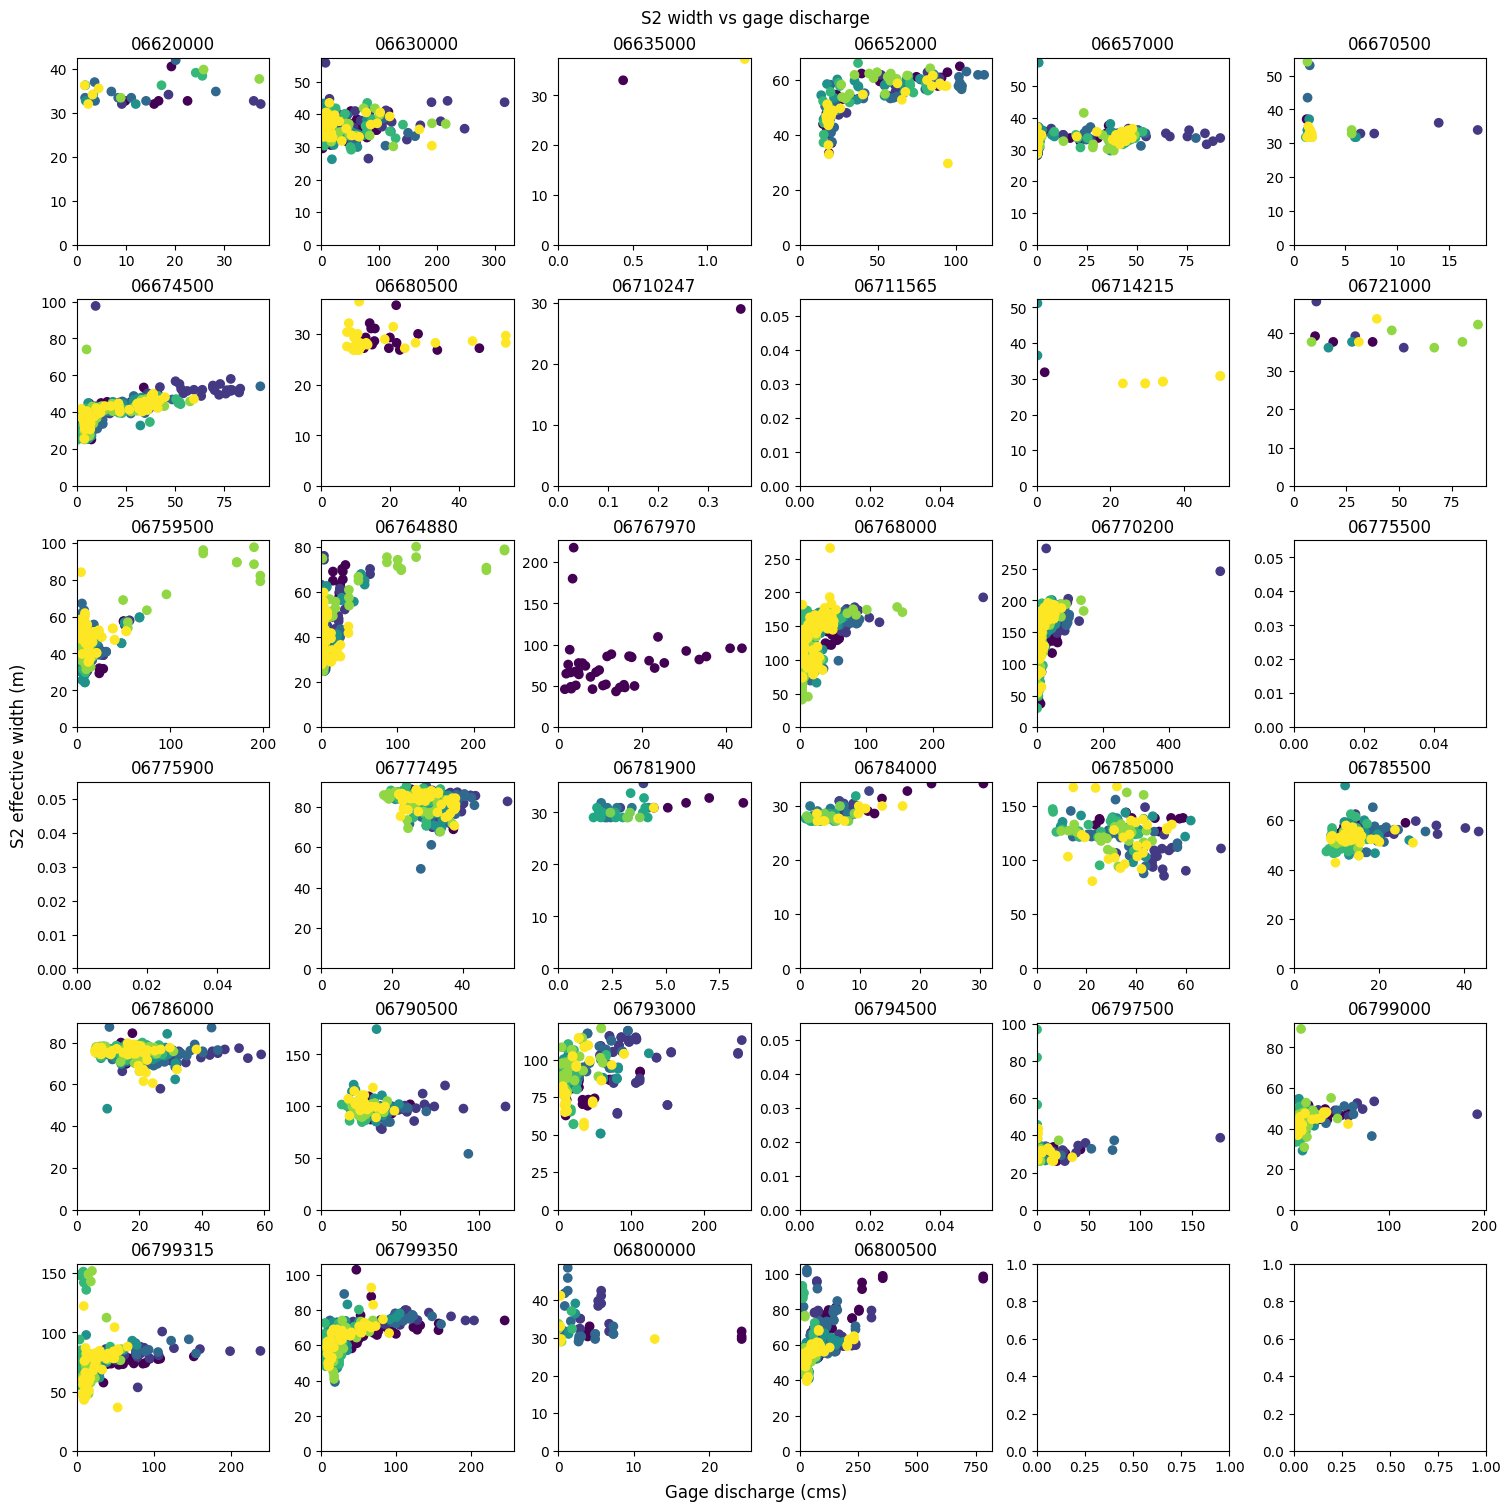

In [14]:
t = wQ



t = t.reset_index()
t.date = pd.to_datetime(t.date)
# t['month'] = t.date.dt.month
t['year'] = t.date.dt.year

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 15), constrained_layout=True)
p = 0
for g, df in t.groupby('site_no'):


    ax = axs.flatten()[p]
    # df1 = df.loc[df.Q_cd == 'A']
    # df2 = df.loc[df.Q_cd != 'A']
    ax.scatter(df.Q_cms, df.sat_width_m, c=df.year)
    # dat2 = ax.scatter(df.median_Q, df.median_w, c='blue')
    # dat2 = ax.scatter(df2.Q_cms, df2.sat_width_m, c='red')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')

# fig.colorbar(dat1, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)


In [ ]:
n = 16 # width varies little with discharge, stage varies a lot with discharge
n = 19 # river at low width is confined to low-flow channel
n = 20 # obscured by bridge and trees
n=26
g = alldata.loc[gage_list[n]]
g = g.loc[g.fraction_snow < 0.2]
g = g.loc[g.Q_cms > 0]
g = g.loc[(g.n_cloud - g.n_cloudriver / g.n_valid) < 0.4]
g = g.loc[g.fraction_edgeriver < 0.3]
g = g.loc[g.Q_cd == 'A']
g = g.reset_index()
g = g.loc[g.n_river > g.n_edgeriver]
g['year'] = g.date.apply(lambda x: x.year)

custom_info = ['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']

fig = go.Figure(
    go.Scatter(
        x=g.Q_cms,
        y=g.sat_width_m,
        mode='markers',
        marker=dict(
            color=g.year,
            colorscale='viridis'),
        customdata = g[['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']],
        hovertemplate='<b>X Value:</b> %{x}<br>' +
                      '<b>Y Value:</b> %{y}<br>' +
                      '<b>fraction_cloud:</b> %{customdata[0]}<br>' +
                      '<b>fraction_snow:</b> %{customdata[1]}<br>' +
                      '<b>n_edge:</b> %{customdata[2]}<br>' +
                      '<b>n_edgeriver:</b> %{customdata[3]}<br>' +
                      '<b>n_valid:</b> %{customdata[4]}<br>' +
                      '<b>n_cloud:</b> %{customdata[5]}<br>' +
                      '<b>n_cloudriver:</b> %{customdata[6]}<br>' +
                      '<b>n_river:</b> %{customdata[7]}<br>' +
                      '<b>img_id:</b> %{customdata[8]}<br>' +
                      '<b>iindex:</b> %{customdata[9]}<br>'
    )
)

fig.update_layout(
    title=gage_list[n],
    xaxis_title=dict(text='Discharge (cms)'),
    yaxis_title=dict(text='Width (m)'),
    yaxis=dict(range=[0, max(g.sat_width_m) + (max(g.sat_width_m) / 5)]),
    scene=dict(aspectmode='auto')
)
fig.show()

Gage Map

In [92]:
Q_medians = Q_filtered.groupby('site_no')['Q_cms'].agg('median')

In [93]:
# gage map imports
gage_pts_map = gage_pts.to_crs(5070).set_index('site_no').join(Q_medians)
states = pygris.states().to_crs(5070)
centerline = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(5070)

Using the default year of 2024


In [95]:
Q_medians

,iindex,geometry,riv_length,Q_cms
site_no,,,,
06764880,225467,POINT (-464243.979 2026736.447),172.516752,3.627341
06775900,75941,POINT (-373315.911 2095034.062),92.934030,6.489541
06775500,77597,POINT (-337963.914 2099287.109),74.194767,14.112625
06770200,217337,POINT (-258715.397 1964898.117),1399.403363,27.105876
06767970,245153,POINT (-299012.803 1968414.531),923.997749,13.432499
06768000,244511,POINT (-296693.994 1968962.261),907.346015,28.168573
06784000,259030,POINT (-228546.174 2005925.649),216.935252,5.072610
06781900,210361,POINT (-308540.292 2026596.612),106.830719,3.513987
06785000,157059,POINT (-203504.243 2024394.848),574.579112,32.306010


In [115]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

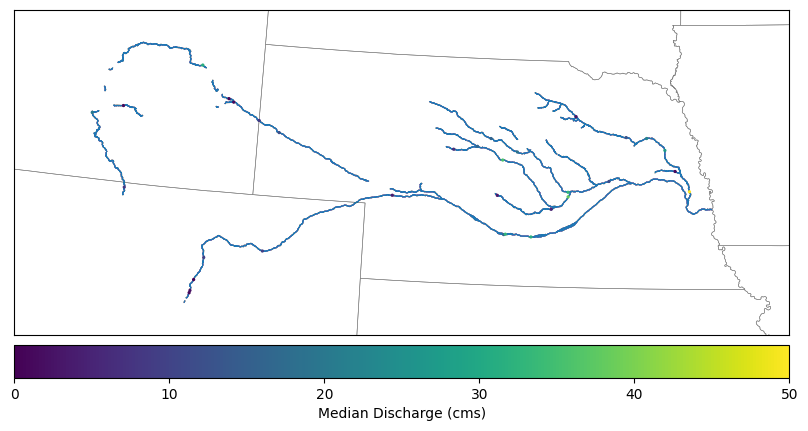

In [130]:
# gage map

l, b, r, t = centerline.total_bounds


fig, ax = plt.subplots(figsize=(10, 6))

states.plot(ax=ax, facecolor='none', edgecolor='tab:gray', linewidth=0.4, zorder=1)
centerline.plot(ax=ax, color='tab:blue', zorder=2, linewidth=0.8)
gQ = gage_pts_map.plot(ax=ax, column='Q_cms', cmap='viridis', zorder=3, legend=False, markersize=1.8)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])


divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='10%', pad=0.1)
plt.colorbar(sm, label='Median Discharge (cms)', cax=cbar_ax, orientation='horizontal')

ax.set_xlim((l - (r - l) / 8), (r + (r - l) / 8))
ax.set_ylim((b - (t - b) / 8), (t + (t - b) / 8))

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('/content/drive/MyDrive/Platte_gage_map_hires_20250929.png', dpi=600, bbox_inches='tight')

Load in-situ widths from USGS

In [ ]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

gage_width_m
site_no  date                    
06775900 2021-05-26     15.853659
         2016-11-16     11.585366
         2016-08-17     11.585366
         2017-06-14     15.853659
         2019-08-21     14.024390
...                           ...
06805500 2025-07-16    378.048780
         2025-08-12    378.048780
         2025-08-27    378.048780
         2025-07-31    378.048780
         2025-08-12    378.048780

[1237 rows x 1 columns]

Pair gage ids with effective width point ids

In [ ]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Import likes and dislikes from river tinder

In [ ]:

def flatten(xss):
    return [x for xs in xss for x in xs]



checked_img_path = '/content/drive/MyDrive/effwidth_results/rt_likes_dislikes'
lols = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'likes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lols.append(lines)

lods = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'dislikes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lods.append(lines)


lols = flatten(lols)
lods = flatten(lods)

lds = pd.DataFrame({'name': lols + lods})
lds['iindex'] = lds.apply(lambda x: int(x['name'][25:]), axis=1)
lds['img_id'] = lds.apply(lambda x: str(x['name'][0:24]), axis=1)
lds['like'] = (np.concatenate([np.repeat(True, len(lols)), np.repeat(False, len(lods))], axis=0))

lds

100%|██████████| 28/28 [00:00<00:00, 212.21it/s]


,name,iindex,img_id,like
0,S2A_14TQL_20240930_0_L2A_201625,201625,S2A_14TQL_20240930_0_L2A,True
1,S2A_15TTF_20240930_0_L2A_153085,153085,S2A_15TTF_20240930_0_L2A,True
2,S2A_15TTF_20240930_0_L2A_202726,202726,S2A_15TTF_20240930_0_L2A,True
3,S2A_15TTF_20240930_0_L2A_203066,203066,S2A_15TTF_20240930_0_L2A,True
4,S2A_15TTF_20240930_0_L2A_202446,202446,S2A_15TTF_20240930_0_L2A,True
...,...,...,...,...
1691,S2A_14TQL_20240913_0_L2A_202726,202726,S2A_14TQL_20240913_0_L2A,False
1692,S2A_14TQL_20240913_0_L2A_203066,203066,S2A_14TQL_20240913_0_L2A,False
1693,S2A_14TQL_20240913_0_L2A_202446,202446,S2A_14TQL_20240913_0_L2A,False
1694,S2A_14TQL_20240913_0_L2A_201888,201888,S2A_14TQL_20240913_0_L2A,False


Join in-situ width and discharge to build rating curves

In [ ]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  Q_cd       d_m d_cd  gage_width_m      logw  \
site_no  date                                                                  
06620000 2011-08-22   11.392119     A       NaN  NaN     46.951220  1.671647   
         2011-10-12    6.206155     A       NaN  NaN     46.951220  1.671647   
         2012-01-30    3.825712  A, e       NaN  NaN     39.634146  1.598070   
         2012-03-30   17.173195     A       NaN  NaN     47.865854  1.680026   
         2012-06-22    4.279129     A       NaN  NaN     37.804878  1.577548   
...                         ...   ...       ...  ...           ...       ...   
06805500 2025-07-16  250.229883     P  1.161585    P    378.048780  2.577548   
         2025-07-31  368.401866     P  1.329268    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-27  121.856002     P  0.865854    P    378.048780  2.577548   

                         logQ  
site_no  date                  
06620000 2011-08-22  1.056605  
         2011-10-12  0.792823  
         2012-01-30  0.582712  
         2012-03-30  1.234851  
         2012-06-22  0.631355  
...                       ...  
06805500 2025-07-16  2.398339  
         2025-07-31  2.566322  
         2025-08-12  2.403716  
         2025-08-12  2.403716  
         2025-08-27  2.085847  

[1222 rows x 7 columns]

Text(0.02, 0.5, 'Gage width (m)')

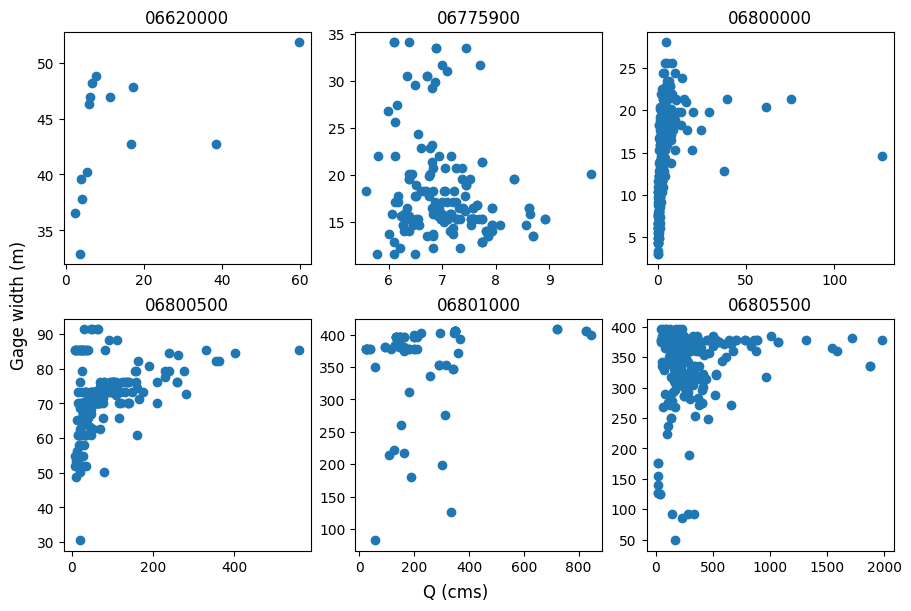

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

Text(0.5, 0.98, 'Power law w/Q rating curves')

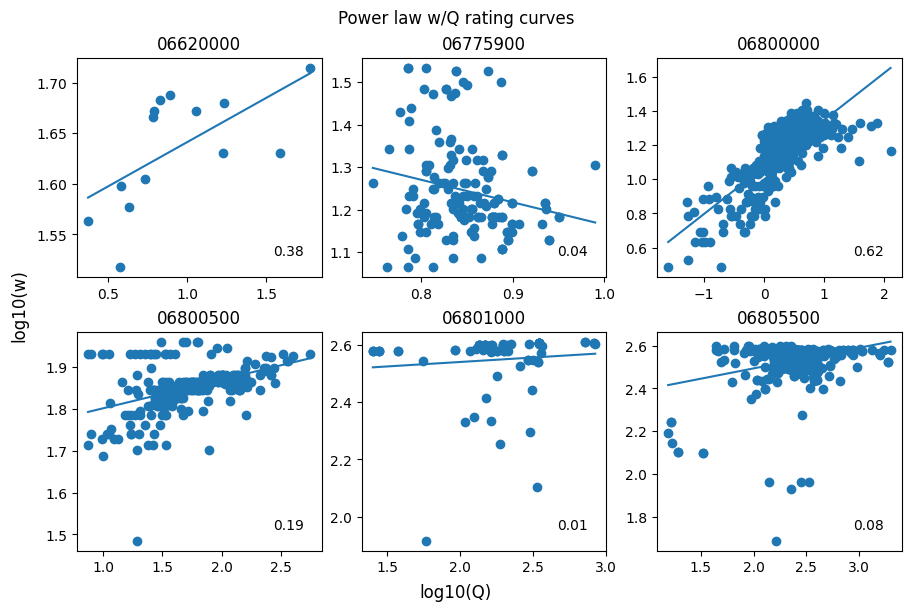

In [ ]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [ ]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06775900,0.087846,1.553382,0.383412,35.758761
06800500,-0.528364,1.692555,0.042450,49.266824
06800000,0.275465,1.072609,0.616782,11.819760
06620000,0.068638,1.732994,0.186642,54.074626
06801000,0.031141,2.477969,0.008993,300.585898
06805500,0.096246,2.301079,0.079128,200.022788


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [ ]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  Q_cd       d_m d_cd  rc_width_m  gage_width_m
site_no  date                                                                 
06620000 2007-11-19    3.967405     A       NaN  NaN   59.439310           NaN
         2007-11-20    3.740696     A       NaN  NaN   59.199738           NaN
         2007-11-21    3.485648  A, e       NaN  NaN   58.913488           NaN
         2007-11-22    3.230601  A, e       NaN  NaN   58.607024           NaN
         2007-11-23    2.862199  A, e       NaN  NaN   58.121987           NaN
...                         ...   ...       ...  ...         ...           ...
06805500 2025-09-18  244.278776     P  1.143293    P  339.550623           NaN
         2025-09-19  273.184153     P  1.198171    P  343.225218           NaN
         2025-09-20  267.799818     P  1.189024    P  342.568258           NaN
         2025-09-21  294.721493     P  1.237805    P  345.741181           NaN
         2025-09-22  265.249343     P  1.185976    P  342.252890           NaN

[39304 rows x 6 columns]

Text(0.5, 0.98, 'Rating curve validation')

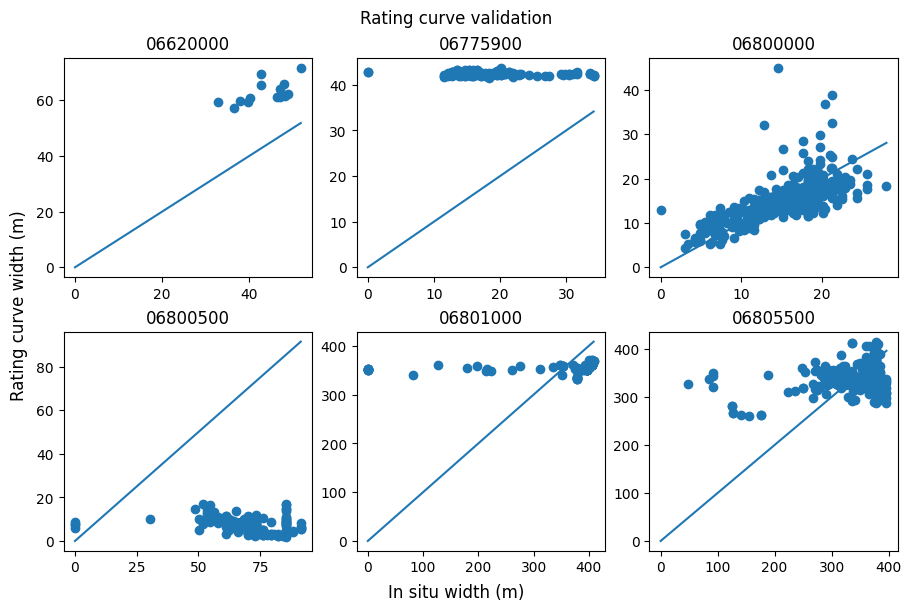

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

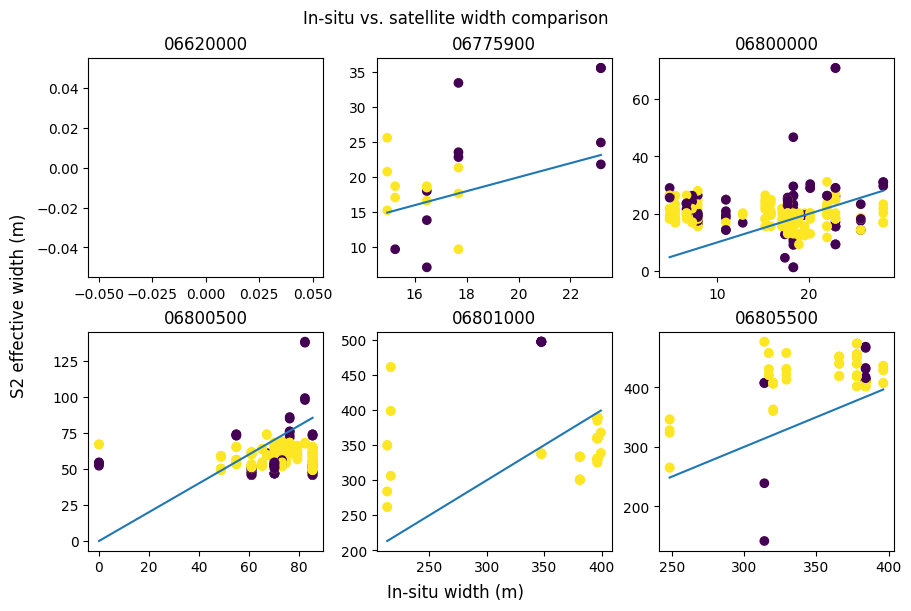

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m, c=df.like)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')